In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time

In [11]:
torch.manual_seed(101)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Transform instance

In [12]:
transform = transforms.ToTensor()

Load CIFAR-10 dataset: train and test

In [13]:
train_data = datasets.CIFAR10(root='train_images/CIFAR_10', train=True, download=True, transform=transform)

Files already downloaded and verified


In [14]:
test_data = datasets.CIFAR10(root='train_images/CIFAR_10', train=False, download=True, transform=transform)

Files already downloaded and verified


Dataloaders

In [15]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Define labels

In [16]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Visualize a batch of images

Label: [1 5 8 1 6 1 6 3 7 9]
Class   car   dog  ship   car  frog   car  frog   cat horse truck


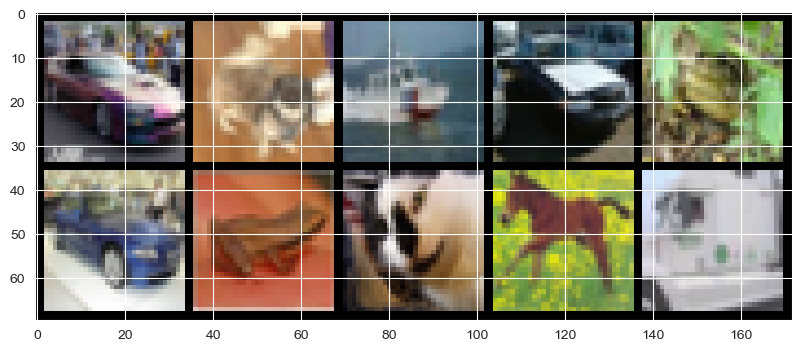

In [17]:
def print_label_images(nrow=5):
    for images, labels in train_loader:
        break
    
    # print the labels
    print('Label:', labels.numpy())
    print('Class', *np.array([class_names[i] for i in labels]))
    
    # print the images
    im = make_grid(images, nrow=nrow)
    plt.figure(figsize=(16, 4))
    plt.imshow(np.transpose(im.numpy(), (1,2, 0)))

print_label_images()

Input Tensor Shape

In [18]:
for images, labels in train_loader:
    break
print("Shape of images:", images.shape)

Shape of images: torch.Size([10, 3, 32, 32])


Convolutional Model:

- RGB images: input_channels = 3
- Kernel size of Conv1 = 3
- Kernel size of Conv2 = 3
- Convolution Stride = 1
- Convolution Padding = 0

- Pool Stride = 2
- Pool Kernel Size = 2

In [45]:
class ConvNetwork(nn.Module):
    def __init__(self, filter1, filter2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, filter1, 4, 1)
        self.conv2 = nn.Conv2d(filter1, filter2, 4, 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # Initialize fully connected layers with placeholder
        self.fc1 = None
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self._initialize_fc1()
        
    def _initialize_fc1(self):
        # Create a dummy tensor with the same size a single CIFAR-10 input
        dummy_input = torch.zeros(1, 3, 32, 32)

        # Pass the dummy input through the conv and pooling layers to calculate the flattened size
        dummy_output = self.pool(F.relu(self.conv1(dummy_input)))
        dummy_output = self.pool(F.relu(self.conv2(dummy_output)))
        
        # Calculate the flattened size
        flattened_size = dummy_output.numel()  # Returns the total number of elements in the tensor
        
        # Now that we know the flattened size, we can initialize the first fully connected layer
        self.fc1 = nn.Linear(flattened_size, 512)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)  
        X = F.relu(self.conv2(X))
        X = self.pool(X)  
        X = X.view(X.size(0), -1)  # Flattening
        X = self.dropout(F.relu(self.fc1(X)))
        X = self.dropout(F.relu(self.fc2(X)))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [46]:
model = ConvNetwork(32, 64).to(device)
model

ConvNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
)

Total parameters of the model

In [47]:
# count the number of parameters used in the model
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  1536
    32
 32768
    64
131072
   256
  2560
    10
819200
   512
______
988010


Loss function and optimizer

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training Loop

In [49]:
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_accurate = []
test_accurate = []

for i in range(epochs):
    trn_acc = 0
    tst_acc = 0
    
    # Training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        # number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_acc = (predicted == y_train).sum()
        trn_acc += batch_acc
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_acc.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_accurate.append(trn_acc)
    
    # testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            # forward pass
            y_val = model(X_test)
            
            # number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_acc += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_accurate.append(tst_acc)

# elapsed time
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 
        

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.67199111  accuracy:  27.820%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.92408144  accuracy:  35.060%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 2.31178260  accuracy:  38.917%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.83761191  accuracy:  41.715%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.27703285  accuracy:  43.556%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.67444366  accuracy:  55.370%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 0.99807250  accuracy:  55.730%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.99379885  accuracy:  56.377%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.05180216  accuracy:  56.797%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.15806758  accuracy:  57.314%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.49648666  accuracy:  62.180%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.28015351  accuracy:  62.505%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.18834615  accuracy:  62.487%
epoch:  2  b

In [50]:
torch.save(model.state_dict(), 'export/cifar_10_cnn.pt')